In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os, csv
import random
import nltk
import re
import string
import collections
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [156]:
bbc_politics_df = pd.DataFrame()
bbc_dir = os.path.join('bbc_news_data', 'Summaries', 'politics')
for file in os.listdir(bbc_dir):
    file_path = os.path.join(bbc_dir, file)
    with open(file_path) as f:
        file_text = pd.DataFrame([f.read()], columns=["Text"])
        bbc_politics_df = pd.concat([bbc_politics_df, file_text], ignore_index=True)
bbc_politics_df['Source'] = 'BBC'

In [157]:
# Randomly selects around 500 sentences from Harry Potter, Book 1.

random.seed(4)
sample_size = 500

harry_potter_df = pd.DataFrame()
hp1_path = os.path.join('harry_potter_data', 'Book1.txt')
with open(hp1_path) as f:
    sentences = nltk.tokenize.sent_tokenize(f.read())
    for sentence in random.sample(sentences, sample_size):
        if 'Rowling' in sentence: #Removes any sentence that contains the title/author header
            continue
        sentence = pd.DataFrame([sentence], columns=["Text"])
        harry_potter_df = pd.concat([harry_potter_df, sentence], ignore_index=True)
harry_potter_df['Source'] = 'Harry Potter'

In [158]:
# Randomly selects 500 sentences from the Amazon musical instruments reviews dataset.

num_reviews = 10261
sample_size = 500
random.seed(9)
skipped_rows = random.sample(range(1, num_reviews), num_reviews - sample_size)

amazon_instruments_path = os.path.join('musical_instruments_amazon_data',
                                      'Musical_instruments_reviews.csv')
amazon_instruments_df = pd.read_csv(amazon_instruments_path, skiprows=skipped_rows)
amazon_instruments_df = amazon_instruments_df.rename(columns={'reviewText': 'Text'})
amazon_instruments_df['Source'] = 'Amazon'
amazon_instruments_df.dropna(inplace=True);

In [159]:
reddit_recipes_path = os.path.join('recipes_reddit_data', 'Recipes.csv')
reddit_recipes_df = pd.read_csv(reddit_recipes_path, encoding_errors='ignore')
reddit_recipes_df = reddit_recipes_df.rename(columns={'comment': 'Text'})
reddit_recipes_df['Source'] = 'Reddit'

In [160]:
text_df = pd.concat([
    bbc_politics_df,
    harry_potter_df,
    amazon_instruments_df[['Text', 'Source']],
    reddit_recipes_df[['Text', 'Source']]
], axis=0, ignore_index=True)

In [161]:
sample = pd.concat([text_df[text_df['Source'] == 'BBC'][:5],
                   text_df[text_df['Source'] == 'Harry Potter'][:5],
                   text_df[text_df['Source'] == 'Amazon'][:5],
                   text_df[text_df['Source'] == 'Reddit'][:5]])
sample

,Text,Source
0,Former Labour leader Neil Kinnock has officially been made a life peer during a ceremony in the ...,BBC
1,It claims Mr Blair said in November 2003 he would stand down as prime minister before the next e...,BBC
2,"Mr Bannatyne has previously given Labour £50,000.Mr Bannatyne said: ""Disunity in the Cabinet has...",BBC
3,"""How is it that peace has not arrived?,"" the cardinal will ask.On Friday, the Cardinal will ask ...",BBC
4,Mr Griffin is the twelfth man to be arrested following the documentary.A party spokesman said Ni...,BBC
417,He \nremembered being picked for teams during gym at his \nold school.,Harry Potter
418,"I’ve been out here for \nhours, I couldn’t remember the new password to get \nin to bed.” \n\n“K...",Harry Potter
419,"“A what?” said Harry, interested.",Harry Potter
420,"Maybe he \nwas imagining it, maybe not, but he thought a faint \nwhispering was coming from the ...",Harry Potter
421,"That’ll take a lot of explaining.” \n\nHermione looked convinced, but Ron didn’t.",Harry Potter


In [162]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2300 non-null   object
 1   Source  2300 non-null   object
dtypes: object(2)
memory usage: 36.1+ KB


In [163]:
"""A simple tokenizer for data preprocessing."""

from nltk.stem.wordnet import WordNetLemmatizer

def tokenizer(text):
    """
    Tokenizes text by making everything lowercase, removing punctuation and unallowed symbols,
    removing any non-ascii code, and lemmatizing words.
    """
    text = text.lower()
    unallowed = '0-9\r\t\n'
    regex = re.compile(r'[' + re.escape(string.punctuation) + unallowed +']')
    nopunct = regex.sub(' ', text)
    words = nopunct.split(' ')
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    words = [word for word in words if len(word) > 2]
    return words

In [164]:
"""Vectorizes the text snippets."""

from sklearn.feature_extraction.text import TfidfVectorizer

kwargs = {
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': 'word',
    'tokenizer': tokenizer,
    'max_features': 20000,
    'ngram_range': (1,2),
    'stop_words': 'english',
}

vectorizer = TfidfVectorizer(**kwargs)
text_df_v = vectorizer.fit_transform(text_df['Text'])

text_df_v.shape

(2300, 20000)

In [165]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_clustering_scores(df, max_num_clusters):
    Scores = collections.namedtuple('scores', ['inertia', 'silhouette'])
    scores = Scores([],[])
    for k in range(1, max_num_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=12)
        kmeans.fit(df)
        scores.inertia.append(kmeans.inertia_)
        if k >= 2:
            scores.silhouette.append(silhouette_score(df, kmeans.labels_))
    return scores

In [166]:
%%time

max_num_clusters = 20
scores = get_clustering_scores(text_df_v, max_num_clusters)

CPU times: user 2min 7s, sys: 8.82 s, total: 2min 16s
Wall time: 46.2 s


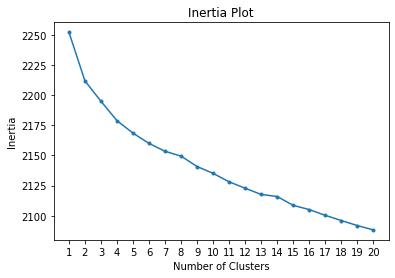

In [167]:
plt.plot(range(1, max_num_clusters + 1), scores.inertia, marker = '.');
plt.xticks(ticks=range(1, max_num_clusters + 1), labels=range(1, max_num_clusters + 1));
plt.xlabel("Number of Clusters");
plt.ylabel("Inertia");
plt.title("Inertia Plot");

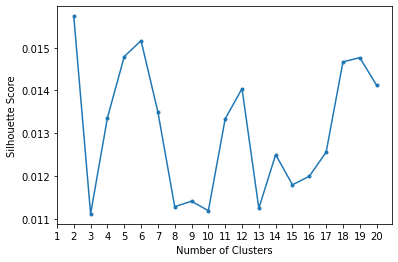

In [168]:
plt.plot(range(2, max_num_clusters + 1), scores.silhouette, marker = '.');
plt.xticks(ticks=range(1, max_num_clusters + 1), labels=range(1, max_num_clusters + 1));
plt.xlabel("Number of Clusters");
plt.ylabel("Silhouette Score");

In [169]:
%%time
"""
Generates B samples of shape arr.shape, where each entry is chosen from a uniform
distribution over the range of observed values in that column of arr.

Input: numpy array
Output: numpy array of shape (B, arr.shape[0], arr.shape[1])
"""
def generate_reference_data(arr, B):
    col_ranges = [(0,0)] * arr.shape[1]
    for j in range(arr.shape[1]):
        col_min, col_max = arr[:, j].min(), arr[:, j].max()
        col_ranges[j] = (col_min, col_max)
    output = np.zeros((B, arr.shape[0], arr.shape[1]))
    for b in range(B):
        for j in range(arr.shape[1]):
            low = col_ranges[j][0]
            high = col_ranges[j][1]
            output[b,:,j] = np.random.uniform(low, high, size=arr.shape[0])
    return output

ref_data = generate_reference_data(text_df_v, 5)

CPU times: user 43.2 s, sys: 1.32 s, total: 44.5 s
Wall time: 45.4 s


In [170]:
# Computes the expected value and estimated variance for the log of inertia for a
# k-clustering using a reference dataset consisting of B simulated samples.

def get_log_inertia_stats(k, ref_data, B):
    log_inertias = []
    for b in range(B):
        print("b = ", b, end=" ")
        kmeans_ref = KMeans(n_clusters=k, random_state=12)
        kmeans_ref.fit(ref_data[b])
        log_inertias.append(np.log(kmeans_ref.inertia_))
    print("k = ", k, ": Done.")
    return (np.mean(log_inertias), np.std(log_inertias)*np.sqrt(1 + 1/20))

In [17]:
%%time

log_inertia_stats = [] # Record of the stats from the simulation over different values of k.
for k in range(1, max_num_clusters + 1):
    log_inertia_stats.append(get_log_inertia_stats(k, ref_data, 5))

b =  0 b =  1 b =  2 b =  3 b =  4 k =  1 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  2 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  3 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  4 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  5 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  6 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  7 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  8 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  9 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  10 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  11 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  12 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  13 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  14 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  15 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  16 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  17 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  18 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  19 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  

In [18]:
log_inertia_stats

[(11.967753417720251, 0.0002049233789235363),
 (11.966498710013138, 0.00020641931866967176),
 (11.96564357791708, 0.00019521949815961312),
 (11.965080787574896, 0.00021108122016162554),
 (11.964541658515977, 0.00019231888526337186),
 (11.96406810006307, 0.0002049539359283045),
 (11.963517307607415, 0.0002186864815213315),
 (11.963044777635888, 0.00018486776896428173),
 (11.962528821086266, 0.00021289215086704185),
 (11.962035513806416, 0.00018905034886540365),
 (11.961513751050857, 0.000190889749800557),
 (11.961024044407988, 0.00020711665212229827),
 (11.960494478069325, 0.0001733268251479078),
 (11.959953902063642, 0.00018274380312017257),
 (11.95948421479694, 0.00020463920887662062),
 (11.958970653213308, 0.000191492220009119),
 (11.95845343708301, 0.00018673042317327718),
 (11.957928248156069, 0.00016304285921104196),
 (11.957429845796762, 0.0002241545113275136),
 (11.956949141003605, 0.00021611864507211888)]

In [171]:
%%time
# Generates reference data uniformly distributed over a box aligned with the first 1000
# principal components of the text_df_v data.

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000)
text_df_v_svd = svd.fit_transform(text_df_v)
ref_data_svd = np.array([svd.transform(ref_data[b]) for b in range(5)])

CPU times: user 40.2 s, sys: 2.13 s, total: 42.3 s
Wall time: 24.5 s


In [19]:
%%time
# Record of the stats from the svd simulation over different values of k.

log_inertia_stats_svd = []
for k in range(1, max_num_clusters + 1):
    log_inertia_stats_svd.append(get_log_inertia_stats(k, ref_data_svd, 5))

b =  0 b =  1 b =  2 b =  3 b =  4 k =  1 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  2 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  3 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  4 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  5 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  6 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  7 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  8 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  9 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  10 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  11 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  12 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  13 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  14 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  15 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  16 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  17 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  18 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  19 : Done.
b =  0 b =  1 b =  2 b =  3 b =  4 k =  

In [20]:
# Graphs gap statistics with error bars given a list of reference mean log inertias
# with SE estimates and observed log inertia.
# Inputs: ref_info = list of tuples (mean_log_inertia, SE_log_inertia) for each cluster size,
#         observed_info = list of inertias for each cluster size

def graph_gaps(ref_info, observed_info, max_num_clusters):
    gaps, errors = [], []
    for i in range(max_num_clusters):
        gaps.append(ref_info[i][0] - np.log(observed_info[i]))
        errors.append(ref_info[i][1])
    plt.errorbar(range(1, max_num_clusters + 1), gaps, yerr=errors);
    plt.xticks(ticks=range(1, max_num_clusters + 1), labels=range(1, max_num_clusters + 1));
    plt.xlabel("Number of Clusters");
    plt.ylabel("Gap Scores");

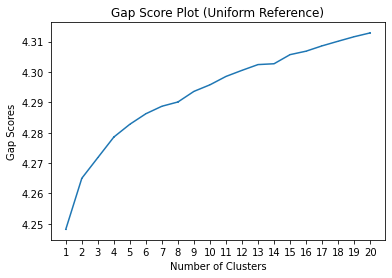

In [48]:
graph_gaps(log_inertia_stats, scores.inertia, 20)
plt.title("Gap Score Plot (Uniform Reference)");

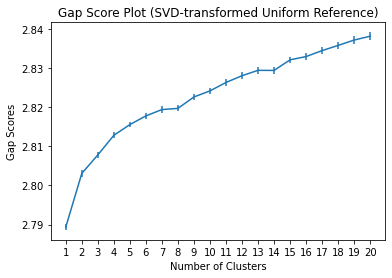

In [21]:
graph_gaps(log_inertia_stats_svd, scores.inertia, 20)
plt.title("Gap Score Plot (SVD-transformed Uniform Reference)");

Optimal k according to AutoElbow: 9


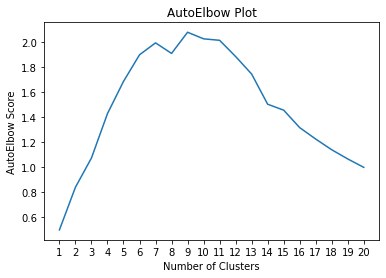

In [172]:
"""Now, onto the AutoElbow algorithm."""

inertias = np.array(scores.inertia)
inertias_norm = (inertias - inertias.min()) / (inertias.max() - inertias.min())
for i in range(1, len(inertias)):
    if inertias_norm[i] > inertias_norm[i-1]:
        inertias_norm[i] = inertias_norm[i+1]

num_clusters_norm = np.linspace(0, 1 ,20)

auto_elbow_scores = []
for k in range(max_num_clusters):
    Q = np.array([1,1])
    g = np.array([num_clusters_norm[k], inertias_norm[k]])
    b = np.linalg.norm(g - Q)**2
    a = np.linalg.norm(g)**2
    c = inertias_norm[k]**2
    auto_elbow_scores.append(b / (a + c))
    
plt.plot(np.arange(1, max_num_clusters+1), auto_elbow_scores);
plt.xticks(ticks=range(1, max_num_clusters + 1), labels=range(1, max_num_clusters + 1));
plt.xlabel("Number of Clusters");
plt.ylabel("AutoElbow Score");
plt.title("AutoElbow Plot");
print("Optimal k according to AutoElbow:", np.argmax(auto_elbow_scores) + 1);

In [173]:
"""Now, the L-method."""

from sklearn.linear_model import LinearRegression

b = max_num_clusters
rms_errors = np.zeros(b-3)
for c in range(2, b - 1): # c is the number of points to include in the left line
    left_line = LinearRegression().fit(np.arange(1, c+1).reshape(-1, 1), inertias[:c])
    left_rmse = np.sqrt(((inertias[:c] - left_line.predict(np.arange(1, c+1).reshape(-1, 1)))**2).sum())
    right_line = LinearRegression().fit(np.arange(c+1, b+1).reshape(-1, 1), inertias[c:b])
    right_rmse = np.sqrt(((inertias[c:b] - right_line.predict(np.arange(c+1, b+1).reshape(-1, 1)))**2).sum())
    rmse = ((c - 1) / (b - 1)) * left_rmse + ((b - c) / (b - 1)) * right_rmse
    rms_errors[c-2] = rmse
    
print("Optimal k according to the L-method:", rms_errors.argmin() + 2)
rms_errors

Optimal k according to the L-method: 5


array([20.27750562, 13.1787923 , 10.69282371, 10.3628302 , 11.36390618,
       13.03541935, 14.31138264, 16.41141998, 18.75474335, 21.66190338,
       24.87875206, 28.25308814, 32.02818423, 35.91343603, 40.14986067,
       44.5145081 , 49.03938407])

In [174]:
# Finally, factionalization.

def get_fac_scores(df, max_num_clusters):
    factionalization_scores = np.zeros(max_num_clusters - 1)
    for k in range(2, max_num_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=12).fit(df)
        alpha = 0
        for i in range(k):
            for x in df[kmeans.labels_ == i]:
                alpha += np.linalg.norm(x - kmeans.cluster_centers_[i])
        beta = 0
        for i in range(k):
            for x in df[kmeans.labels_ == i]:
                for j in range(k):
                    if j == i:
                        continue
                    else:
                        beta += (1 / np.linalg.norm(x - kmeans.cluster_centers_[j]))
        beta /= k - 1
        factionalization_scores[k-2] = 1 / (alpha + beta)
        print('k =', k, ': Done.')
    return factionalization_scores

In [118]:
fac_scores = get_fac_scores(text_df_v, 50)

k = 2 : Done.
k = 3 : Done.
k = 4 : Done.
k = 5 : Done.
k = 6 : Done.
k = 7 : Done.
k = 8 : Done.
k = 9 : Done.
k = 10 : Done.
k = 11 : Done.
k = 12 : Done.
k = 13 : Done.
k = 14 : Done.
k = 15 : Done.
k = 16 : Done.
k = 17 : Done.
k = 18 : Done.
k = 19 : Done.
k = 20 : Done.
k = 21 : Done.
k = 22 : Done.
k = 23 : Done.
k = 24 : Done.
k = 25 : Done.
k = 26 : Done.
k = 27 : Done.
k = 28 : Done.
k = 29 : Done.
k = 30 : Done.
k = 31 : Done.
k = 32 : Done.
k = 33 : Done.
k = 34 : Done.
k = 35 : Done.
k = 36 : Done.
k = 37 : Done.
k = 38 : Done.
k = 39 : Done.
k = 40 : Done.
k = 41 : Done.
k = 42 : Done.
k = 43 : Done.
k = 44 : Done.
k = 45 : Done.
k = 46 : Done.
k = 47 : Done.
k = 48 : Done.
k = 49 : Done.
k = 50 : Done.


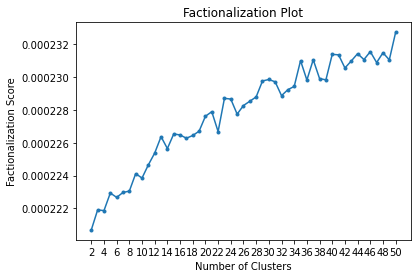

In [121]:
max_num_clusters = 50
plt.plot(np.arange(2, max_num_clusters+1), fac_scores, marker='.');
plt.xticks(ticks=range(2, max_num_clusters + 1, 2), labels=range(2, max_num_clusters + 1, 2));
plt.xlabel("Number of Clusters");
plt.ylabel("Factionalization Score");
plt.title("Factionalization Plot");
#print("Optimal k according to Factionalization Method:", np.argmax(auto_elbow_scores) + 1);

In [47]:
"""We now see how well-aligned a four-clustering is with the known document sources."""

kmeans = KMeans(n_clusters=4, random_state=12).fit(text_df_v)

for k in range(4):
    for source in text_df['Source'].unique():
        source_k_count = np.sum((text_df['Source'] == source) & (kmeans.labels_ == k))
        k_count = np.sum((kmeans.labels_ == k))
        proportion = source_k_count / k_count
        print(f"Proportion of cluster {k} from source {source}: ", proportion)
    print('')

Proportion of cluster 0 from source BBC:  0.027860696517412936
Proportion of cluster 0 from source Harry Potter:  0.4218905472636816
Proportion of cluster 0 from source Amazon:  0.4955223880597015
Proportion of cluster 0 from source Reddit:  0.05472636815920398

Proportion of cluster 1 from source BBC:  0.9025522041763341
Proportion of cluster 1 from source Harry Potter:  0.0951276102088167
Proportion of cluster 1 from source Amazon:  0.002320185614849188
Proportion of cluster 1 from source Reddit:  0.0

Proportion of cluster 2 from source BBC:  0.0
Proportion of cluster 2 from source Harry Potter:  0.001876172607879925
Proportion of cluster 2 from source Amazon:  0.0
Proportion of cluster 2 from source Reddit:  0.99812382739212

Proportion of cluster 3 from source BBC:  0.0
Proportion of cluster 3 from source Harry Potter:  0.0
Proportion of cluster 3 from source Amazon:  0.0
Proportion of cluster 3 from source Reddit:  1.0



In [72]:
"""Samples of interestingly-clustered documents."""

#pd.options.display.max_colwidth = 500

print("BBC, cluster 0: \n", text_df[(text_df['Source'] == 'BBC') & (kmeans.labels_ == 0)][:3]['Text'])
print('')
print("Reddit, cluster 0: \n", text_df[(text_df['Source'] == 'Reddit') & (kmeans.labels_ == 0)][:3]['Text'])
print('')
print("Harry Potter, cluster 0: \n", text_df[(text_df['Source'] == 'Harry Potter') & (kmeans.labels_ == 0)][:3]['Text'])
print('')
print("Harry Potter, cluster 1: \n", text_df[(text_df['Source'] == 'Harry Potter') & (kmeans.labels_ == 1)][:3]['Text'])
print('')
print("Amazon, cluster 1: \n", text_df[(text_df['Source'] == 'Amazon') & (kmeans.labels_ == 1)][:3]['Text'])
print('')


BBC, cluster 0: 
 3     "How is it that peace has not arrived?," the c...
6     The ballot will ask residents to vote for or a...
13    Downing Street has confirmed British troops ar...
Name: Text, dtype: object

Reddit, cluster 0: 
 1414    The simplest recipes are some of the hardest t...
1434    **Recipe here originally:** [**Orange-Maple Ro...
1562    Hi, folks! I'm hoping I can pick your brains a...
Name: Text, dtype: object

Harry Potter, cluster 0: 
 417    He \nremembered being picked for teams during ...
418    I’ve been out here for \nhours, I couldn’t rem...
420    Maybe he \nwas imagining it, maybe not, but he...
Name: Text, dtype: object

Harry Potter, cluster 1: 
 419                    “A what?” said Harry, interested.
422    Everyone says \nHufflepuff are a lot o’ duffer...
438                               “Is it true?” he said.
Name: Text, dtype: object

Amazon, cluster 1: 
 1090    Okay here we go again what can be said about t...
Name: Text, dtype: object



In [45]:
"""Same, but for a five-clustering."""

kmeans = KMeans(n_clusters=5, random_state=12).fit(text_df_v)

for k in range(5):
    for source in text_df['Source'].unique():
        source_k_count = np.sum((text_df['Source'] == source) & (kmeans.labels_ == k))
        k_count = np.sum((kmeans.labels_ == k))
        proportion = source_k_count / k_count
        print(f"Proportion of cluster {k} from source {source}: ", proportion)
    print('')

Proportion of cluster 0 from source BBC:  0.029157667386609073
Proportion of cluster 0 from source Harry Potter:  0.36393088552915764
Proportion of cluster 0 from source Amazon:  0.5377969762419006
Proportion of cluster 0 from source Reddit:  0.06911447084233262

Proportion of cluster 1 from source BBC:  0.0
Proportion of cluster 1 from source Harry Potter:  0.0
Proportion of cluster 1 from source Amazon:  0.0
Proportion of cluster 1 from source Reddit:  1.0

Proportion of cluster 2 from source BBC:  0.9285714285714286
Proportion of cluster 2 from source Harry Potter:  0.06904761904761905
Proportion of cluster 2 from source Amazon:  0.002380952380952381
Proportion of cluster 2 from source Reddit:  0.0

Proportion of cluster 3 from source BBC:  0.0
Proportion of cluster 3 from source Harry Potter:  1.0
Proportion of cluster 3 from source Amazon:  0.0
Proportion of cluster 3 from source Reddit:  0.0

Proportion of cluster 4 from source BBC:  0.0
Proportion of cluster 4 from source Harry 

In [107]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 4
lda = LatentDirichletAllocation(n_components=num_topics, random_state=34)
text_topics = lda.fit_transform(text_df_v)

In [108]:
num_words = 20
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_word_indices = np.argsort(topic)[:-num_words - 1:-1]
    top_words = [feature_names[j] + ',' for j in top_word_indices]
    print(f"Topic {(i+1)}:")
    print(' '.join(top_words) + "\n")

Topic 1:
harry, guitar, string, great, good, like, work, sound, pedal, said, just, pick, strap, price, really, quality, know, use, thing, cable,

Topic 2:
add, cup, minute, sugar, tsp, oil, salt, tbsp, egg, sauce, dough, butter, water, flour, mix, pepper, heat, cook, recipe, ingredient,

Topic 3:
said, labour, blair, election, party, government, minister, tory, lord, howard, tax, say, people, brown, prime minister, prime, new, chancellor, told, public,

Topic 4:
mcgonagall, professor mcgonagall, fred, cloak, thinking, gryffindor, scrambled, lamp, sent, dursley, nevilles, professor, rattled, followed, tap, distance, demanded, ordinary, mom, dream,



In [153]:
"""Gets the texts from each source most aligned with each topic."""

pd.options.display.max_colwidth = 100

text_topics = pd.DataFrame(text_topics) #So that the indices are preserved when masking on source below.

for i, topic in enumerate(['Music?', 'Recipes', 'Politics', 'HP']):
    print(f'\n\nTopic {i+1} ({topic}): ')
    for source in text_df['Source'].unique():
        text_idx = text_topics[text_df['Source'] == source][i].idxmax()
        print(f'\nSource {source}: ')
        print(text_df.iloc[text_idx]['Text'][:500])



Topic 1 (Music?): 

Source BBC: 
MPs will be thrown out of the Commons if they use Blackberries in the chamber Speaker Michael Martin has ruled.The use of electronic devices in the Commons chamber has long been frowned on.The Speaker chairs debates in the Commons and is charged with ensuring order in the chamber and enforcing rules and conventions of the House.The £200 handheld computers can be used as a phone, pager or to send e-mails.

Source Harry Potter: 
Great Uncle Algie was so pleased he 
bought me my toad.” 

On Harry’s other side, Percy Weasley and Hermione 
were talking about lessons (“I do hope they start right 
away, there’s so much to learn, I’m particularly 
interested in Transfiguration, you know, turning 
something into something else, of course, it’s 
supposed to be very difficult — “You’ll be starting 
small, just matches into needles and that sort of 
thing — ”).

Source Amazon: 
I really can't say enough positive things about the Apogee JAM.  Not even 3 years ago,